# [Tutorial 05: Ridge and Lasso Regression](https://franciszheng.com/dsper2020/tutorials/tutorial05/)

In [9]:
import itertools
import pandas as pd
import numpy as np
import copy

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Reset all styles to the default:
plt.rcParams.update(plt.rcParamsDefault)
# Then make graphs inline:
%matplotlib inline

# Set custom style settings:
# NB: We need to separate "matplotlib inline" call and these settings into different
# cells, otherwise the parameters are not set. This is a bug somewhere in Jupyter
plt.rcParams['figure.figsize'] = (7, 6)
plt.rcParams['font.size'] = 24
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'large'
plt.rcParams['lines.markersize'] = 10

## Loading Data

In [10]:
hittersDF = pd.read_csv('Hitters.csv', na_values=[""])
# The first column has no name in the csv file:
hittersDF.rename(columns={hittersDF.columns[0] : "Name"}, inplace=True, copy=False)
hittersDF.set_index('Name', inplace=True)
hittersDF.dropna(inplace=True)

#-- CREATE X and y:

# Convert categorical variables into dummies:
dummies = pd.get_dummies(hittersDF[['League', 'Division', 'NewLeague']])
X = hittersDF.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1)
cat_features = ['League_N', 'Division_W', 'NewLeague_N']
num_features = list(X.columns)

X = pd.concat([X, dummies[cat_features]], axis=1).astype('float64')
y = hittersDF.Salary

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Name,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1.0,1.0,1.0
-Alvin Davis,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0.0,1.0,0.0
-Andre Dawson,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1.0,0.0,1.0
-Andres Galarraga,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1.0,0.0,1.0
-Alfredo Griffin,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0.0,1.0,0.0
-Al Newman,185.0,37.0,1.0,23.0,8.0,21.0,2.0,214.0,42.0,1.0,30.0,9.0,24.0,76.0,127.0,7.0,1.0,0.0,0.0
-Argenis Salazar,298.0,73.0,0.0,24.0,24.0,7.0,3.0,509.0,108.0,0.0,41.0,37.0,12.0,121.0,283.0,9.0,0.0,1.0,0.0
-Andres Thomas,323.0,81.0,6.0,26.0,32.0,8.0,2.0,341.0,86.0,6.0,32.0,34.0,8.0,143.0,290.0,19.0,1.0,1.0,1.0
-Andre Thornton,401.0,92.0,17.0,49.0,66.0,65.0,13.0,5206.0,1332.0,253.0,784.0,890.0,866.0,0.0,0.0,0.0,0.0,0.0,0.0


## Creating Data Pipelines

In [11]:
# From here: https://kiwidamien.github.io/introducing-the-column-transformer.html
# and from "Hands-On Machine Learning with Scikit-Learn & TensorFlow" by Aurélien Géron.

# Feature scaling is super important for Ridge and Lasso.

# Pipeline for numerical columns:
num_pipeline = Pipeline([
    # Replace missing numerical values with their median values.
    # Actually, our dataset does not have missing values (we dropped them all),
    # but in case we decide not to drop the missing values, we can do the imputation.
    ('impute', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

# Pipeline for categorical columns:
cat_pipeline = Pipeline([
    # Do not scale data. Replace missing values with the most frequent values:
    ('impute', SimpleImputer(strategy='most_frequent'))
])

full_preprocess_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_features),
    ('categorical', cat_pipeline, cat_features)
])

train_preprocess_pipeline = copy.copy(full_preprocess_pipeline)

X_processed = full_preprocess_pipeline.fit_transform(X)

#-- SPLIT INTO TWO TRAIN AND TEST DATASETS:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
X_train_processed = train_preprocess_pipeline.fit_transform(X_train)
# Note that we scale test data using the train data's mean and variance. This is important.
X_test_processed = train_preprocess_pipeline.transform(X_test)
print(X_train_processed[:4])

[[-1.22544785 -0.95709474 -0.92570099 -1.4022036  -1.13030146 -1.58538045
   2.01095013  0.62071676  0.65160576  0.12446442  0.41391291  0.42474454
  -0.01814744 -0.36319346 -0.42345049 -0.59896236  0.          1.
   0.        ]
 [ 0.8036835   0.44319078 -1.17625229 -0.44088545 -0.28021565 -0.19298262
   0.75450593  1.26958867  1.31158886 -0.31559698  1.07321939  0.50410693
   0.03020472 -0.26634017  1.78498762  1.91691963  1.          1.
   1.        ]
 [ 1.70551966  2.27433337  0.32705552  2.05854173  0.2993883   0.54672873
  -0.50193827 -0.11288459  0.08002686 -0.50741861 -0.00313677 -0.31502626
  -0.22364413  0.16782974 -0.60689902 -0.59896236  1.          1.
   1.        ]
 [-0.56956701 -0.72012334 -1.4268036  -0.78695998 -0.78253908 -0.58459451
  -0.50193827 -0.98179368 -0.96862989 -0.81207651 -0.95683125 -0.8762317
  -0.89654505 -0.56691934  1.15702918  0.65897863  1.          0.
   1.        ]]


## Print Function

In [23]:
# This function prints results from ridge or lasso regression.
# It prints coefficients for scaled and unscaled data:
def printCoefs(regr_res, coef_names, num_features_idx, mean, var):
    scaled_coefs = np.hstack((regr_res.intercept_, regr_res.coef_))
    
    # Only numerical features are scaled. So, we need to extract them, unscale
    # the coefficients, then merge coefficients for numerical and categorical
    # features.

    cat_features_idx = [x for x in range(len(regr_res.coef_))\
                        if x not in num_features_idx]

    unscaled_num_coefs = regr_res.coef_[num_features_idx] / np.sqrt(var)
    unscaled_intercept = regr_res.intercept_ - np.sum(unscaled_num_coefs * mean)

    unscaled_coefs = np.array([None] * (len(regr_res.coef_) + 1))
    # Intercept goes first, then the rest of coefficients:
    unscaled_coefs[0] = unscaled_intercept
    unscaled_coefs[[i+1 for i in num_features_idx]] = unscaled_num_coefs
    unscaled_coefs[[i+1 for i in cat_features_idx]] = ridge.coef_[cat_features_idx]

    results = pd.DataFrame(data={'Scaled' : scaled_coefs,
                                  'Unscaled' : unscaled_coefs},
                            index=['Intercept']+coef_names)
    print(results)

## Ridge Regression

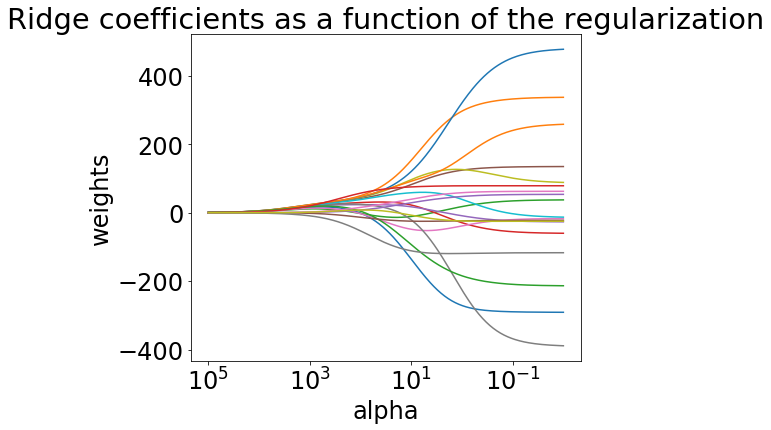

In [13]:
# NB: glmnet uses (1/N)*||y - Xw||^2_2 + lambda/2 * ||w||^2_2, while
# Ridge uses ||y - Xw||^2_2 + alpha * ||w||^2_2. So, there is a difference.
alphas = 10**np.linspace(5, -2, 300)

# NB: Do not use the normalize option of Ridge, use scale or StandardScaler from sklearn.preprocessing
# See here: https://stackoverflow.com/questions/24098212/what-does-the-option-normalize-true-in-lasso-sklearn-do
ridge = Ridge(fit_intercept=True, normalize=False, tol=1e-12)

coefs = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_processed, y)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

In [14]:
# Perform ridge on train data for alpha = 4 and show prediction error on test data:
ridge2 = Ridge(alpha=4, normalize=False, tol=1e-12)
ridge2.fit(X_train_processed, y_train)
yhat = ridge2.predict(X_test_processed)
print("Ridge regression with alpha =", 4)
print("MSE:", mean_squared_error(y_test, yhat))

Ridge regression with alpha = 4
MSE: 102084.02878693413


### Choosing an Optimal α

In [15]:
# NB: Don't use 'RidgeCV'!
# See here: https://stackoverflow.com/questions/39466671/use-of-scaler-with-lassocv-ridgecv

ridge_pipeline = Pipeline([
    ('scaler', train_preprocess_pipeline),
    ('regressor', Ridge(fit_intercept=True, normalize=False, tol=1e-12))
])

# We need to supply parameter alpha to Ridge. Note the convention adopted to
# name the parameters: name of the pipeline step, followed by a double underscore (__),
# then finally the name of the parameter within the step
pipeline_params = {'regressor__alpha': alphas}

# Using our pipline with GridSearchCV allows us to scale the train part of X_train in each fold
# and then apply that scaling to the test part of X_train in each fold. This is the correct way to
# K-fold cross-validation. This way there is no information leakage from the train part of a fold to
# the test part of a fold.
kf = KFold(n_splits=10, shuffle=True, random_state=1)
gridsearch = GridSearchCV(ridge_pipeline, param_grid=pipeline_params, cv=kf,
                          scoring='neg_mean_squared_error',
                          return_train_score=False, # We don't need them
                          n_jobs=6, # Use 6 CPU cores
                          verbose=1, iid=False).fit(X_train, y_train)

best_ridge_alpha = gridsearch.best_params_['regressor__alpha']
print("Best alpha:", best_ridge_alpha)
print('MSE on the test dataset is: ', -gridsearch.score(X_test, y_test))

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 2060 tasks      | elapsed:    8.0s


Best alpha: 69.09790545715646
MSE on the test dataset is:  101735.58726985169


[Parallel(n_jobs=6)]: Done 3000 out of 3000 | elapsed:   10.9s finished
/Users/daehyung/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


### Printing Results

In [16]:
#COEFFICIENTS ON THE FULL DATA SET:
ridge.set_params(alpha=best_ridge_alpha)
fitted_scaler = full_preprocess_pipeline.transformers_[0][1].steps[1][1]
displaybd("Regression coefficients of the optimal ridge regression on the full dataset:")
printRidgeCoefs(ridge, num_features + cat_features,
                list(range(len(num_features))),
                fitted_scaler.mean_, fitted_scaler.var_)

**Regression coefficients of the optimal ridge regression on the full dataset:**

                 Scaled  Unscaled
Intercept    577.485786    163.13
AtBat       -290.926712  -1.97873
Hits         337.235023   7.48755
HmRun         37.494045   4.28972
Runs         -60.017331  -2.35443
RBI          -26.662596   -1.0321
Walks        134.927434   6.22453
Years        -17.051308  -3.56387
CAtBat      -388.771534 -0.170347
CHits         88.555476  0.136878
CHmRun       -12.903281 -0.157278
CRuns        477.616374   1.44483
CRBI         258.394540  0.800597
CWalks      -213.378882 -0.809623
PutOuts       78.761990  0.281895
Assists       53.657052  0.370548
Errors       -22.191244  -3.36537
League_N      62.571806   62.5718
Division_W  -116.894468  -116.894
NewLeague_N  -24.797541  -24.7975


## Lasso Regression

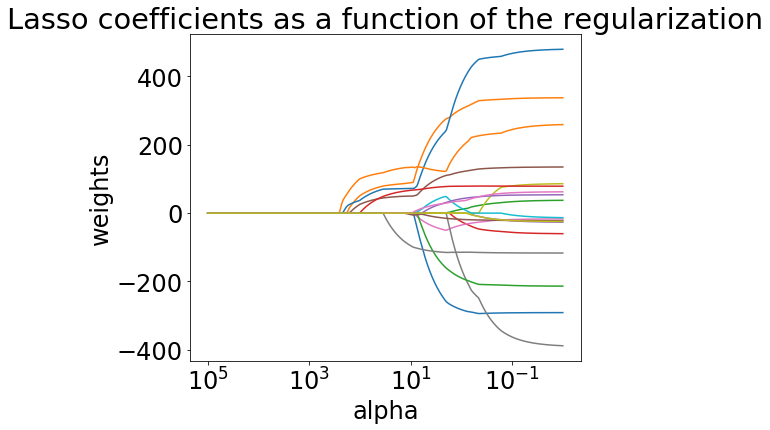

In [17]:
lasso = Lasso(fit_intercept=True, normalize=False, tol=1e-12, max_iter=100000)

coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_processed, y)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

### Choosing an Optimal α

In [18]:
# NB: Again, don't use 'LassoCV'!
# See here: https://stackoverflow.com/questions/39466671/use-of-scaler-with-lassocv-ridgecv

lasso_pipeline = Pipeline([
    ('scaler', train_preprocess_pipeline),
    ('regressor', Lasso(fit_intercept=True, normalize=False, tol=1e-12, max_iter=10000))
])

# We need a much lower alpha for Lasso (it means a different thing in Lasso versus Ridge).
# I just divide it by 10:
pipeline_params = {'regressor__alpha': alphas / 10}

# Using our pipline with GridSearchCV allows us to scale the train part of X_train in each fold
# and then apply that scaling to the test part of X_train in each fold. This is the correct way to
# K-fold cross-validation. This way there is no information leakage from the train part of a fold to
# the test part of a fold.
kf = KFold(n_splits=10, shuffle=True, random_state=1)
gridsearch = GridSearchCV(lasso_pipeline, param_grid=pipeline_params, cv=kf,
                          scoring='neg_mean_squared_error',
                          return_train_score=False, # We don't need them
                          n_jobs=6, # Use 6 CPU cores
                          verbose=1, iid=False).fit(X_train, y_train)

best_lasso_alpha = gridsearch.best_params_['regressor__alpha']
print("Best alpha:", best_lasso_alpha)
print('MSE on the test dataset is: ', -gridsearch.score(X_test, y_test))

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done 2060 tasks      | elapsed:   11.1s


Best alpha: 0.7181039092537357
MSE on the test dataset is:  107596.2015393248


[Parallel(n_jobs=6)]: Done 3000 out of 3000 | elapsed:   19.8s finished
/Users/daehyung/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


### Printing Results

In [28]:
lasso.set_params(alpha=best_lasso_alpha)
fitted_scaler = full_preprocess_pipeline.transformers_[0][1].steps[1][1]
displaybd("Regression coefficients of the optimal lasso regression on the full dataset:")
printCoefs(lasso, num_features + cat_features,
                list(range(len(num_features))),
                fitted_scaler.mean_, fitted_scaler.var_)

**Regression coefficients of the optimal lasso regression on the full dataset:**

                 Scaled  Unscaled
Intercept    577.417128   162.994
AtBat       -291.156068  -1.98029
Hits         337.534768    7.4942
HmRun         37.410636   4.28018
Runs         -60.160402  -2.36004
RBI          -26.527714  -1.02687
Walks        134.920241    6.2242
Years        -16.900832  -3.53242
CAtBat      -388.183560 -0.170089
CHits         86.005263  0.132936
CHmRun       -13.326362 -0.162435
CRuns        479.406526   1.45025
CRBI         259.079389  0.802719
CWalks      -213.675997  -0.81075
PutOuts       78.775224  0.281942
Assists       53.613395  0.370247
Errors       -22.122089  -3.35488
League_N      62.292836   62.5718
Division_W  -116.810487  -116.894
NewLeague_N  -24.458230  -24.7975
